# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Our objective is to determine which factors most influence the sales price of a used car. We will produce a list of the most important factors and their weights. This analysis will be performed using the provided Kaggle dataset.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('data/vehicles.csv')

In [4]:
df.tail()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy
426879,7301591129,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,NaN,coupe,NaN,wy


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

There are a large number of null values in this dataset. The feature "size" has by far the most nulls. We will drop this column, since we expect that there would be a strong correlation between "size" and "cylinders" and "type." We will also drop the VIN column, since it will not impact price. We will set the index to the "id" column.

#### Non-numeric features

Next, we will examine each of the non-numeric features and decide how to approach each.

In [6]:
df.region.value_counts()

columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
                           ... 
meridian                     28
southwest MS                 14
kansas city                  11
fort smith, AR                9
west virginia (old)           8
Name: region, Length: 404, dtype: int64

With 404 unique values, the region column may impact the performance of our model if we use one-hot encoding. It appears we will need to drop this column for performance reasons. If the "state" column turns out to be a major factor in determining vehicle price, we can revisit the most lucrative regions in the most lucrative states.

In [7]:
print(df.manufacturer.value_counts())
print(len(df.manufacturer.value_counts()))

ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick               5501
mazda               5427
infiniti            4802
lincoln             4220
volvo               3374
mitsubishi          3292
mini                2376
pontiac             2288
rover               2113
jaguar              1946
porsche             1384
mercury             1184
saturn              1090
alfa-romeo           897
tesla                868
fiat                 792
harley-davidson      153
ferrari               95
datsun                63
aston-martin          24


We will keep the "manufacturer" feature and use one-hot encoding.

In [8]:
print(len(df.model.value_counts()))
#print(df.model.value_counts()[df.model.value_counts() > 1000])
#print(len(df.model.value_counts()[df.model.value_counts() > 1000]))

29649


There are 29,649 unique entres for "model" in the dataset, which would be very unwieldy for our model. 

In [9]:
df.condition.value_counts()

good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
Name: condition, dtype: int64

"Condition" could use ordinal encoding, as there appears to be a clear progression from "new" condition to "salvage." Unfortunately, "condition" has a very high number of nulls, so we will use one-hot instead.

In [10]:
df.cylinders.value_counts()

6 cylinders     94169
4 cylinders     77642
8 cylinders     72062
5 cylinders      1712
10 cylinders     1455
other            1298
3 cylinders       655
12 cylinders      209
Name: cylinders, dtype: int64

While it is tempting to use ordinal encoding for number of cylinders, the "other" column is a problem. We will use one-hot encoding.

In [11]:
df.fuel.value_counts()

gas         356209
other        30728
diesel       30062
hybrid        5170
electric      1698
Name: fuel, dtype: int64

We will use one-hot encoding for fuel type.

In [12]:
df.title_status.value_counts()

clean         405117
rebuilt         7219
salvage         3868
lien            1422
missing          814
parts only       198
Name: title_status, dtype: int64

We will use one-hot encoding for title status, as the ranking of these values is a bit ambiguous.

In [13]:
df.transmission.value_counts()

automatic    336524
other         62682
manual        25118
Name: transmission, dtype: int64

We will use one-hot encoding for transmission type.

In [14]:
df.drive.value_counts()

4wd    131904
fwd    105517
rwd     58892
Name: drive, dtype: int64

We will use one-hot encoding for drive type.

In [15]:
df.type.value_counts()

sedan          87056
SUV            77284
pickup         43510
truck          35279
other          22110
coupe          19204
hatchback      16598
wagon          10751
van             8548
convertible     7731
mini-van        4825
offroad          609
bus              517
Name: type, dtype: int64

We will use one-hot encoding for vehicle type.

In [16]:
df.paint_color.value_counts()

white     79285
black     62861
silver    42970
blue      31223
red       30473
grey      24416
green      7343
custom     6700
brown      6593
yellow     2142
orange     1984
purple      687
Name: paint_color, dtype: int64

We will use one-hot encoding for paint color.

In [17]:
df.state.value_counts()

ca    50614
fl    28511
tx    22945
ny    19386
oh    17696
or    17104
mi    16900
nc    15277
wa    13861
pa    13753
wi    11398
co    11088
tn    11066
va    10732
il    10387
nj     9742
id     8961
az     8679
ia     8632
ma     8174
mn     7716
ga     7003
ok     6792
sc     6327
mt     6294
ks     6209
in     5704
ct     5188
al     4955
md     4778
nm     4425
mo     4293
ky     4149
ar     4038
ak     3474
la     3196
nv     3194
nh     2981
dc     2970
me     2966
hi     2964
vt     2513
ri     2320
sd     1302
ut     1150
wv     1052
ne     1036
ms     1016
de      949
wy      610
nd      410
Name: state, dtype: int64

We will use one-hot encoding for state.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

We will start by setting the index to the "id" column and dropping the VIN, size, model, and region columns, as discussed earlier.

In [18]:
df = df.set_index('id')
df = df.drop('VIN', axis = 1)
df = df.drop('size', axis = 1)
df = df.drop('region', axis = 1)
df = df.drop('model', axis = 1)
df.tail()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
id,,,,,,,,,,,,,
7301591192,23590,2019.0,nissan,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,NaN,wy
7301591187,30590,2020.0,volvo,good,NaN,gas,12029.0,clean,other,fwd,sedan,red,wy
7301591147,34990,2020.0,cadillac,good,NaN,diesel,4174.0,clean,other,NaN,hatchback,white,wy
7301591140,28990,2018.0,lexus,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy
7301591129,30590,2019.0,bmw,good,NaN,gas,22716.0,clean,other,rwd,coupe,NaN,wy


Next, we will perform encoding on the non-numeric features. We will keep an eye on all features with an "other" value: cylinders, fuel, transmission, and (vehicle) type  so we don't confuse ourselves later.

In [19]:
dummies = pd.get_dummies(df[['manufacturer', 'condition', 'cylinders','fuel','title_status','transmission','drive','type','paint_color','state']], \
                        prefix=['manufacturer', 'condition', 'cylinders','fuel','title_status','transmission','drive','type','paint_color','state'])
dummies.head()


,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_datsun,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
id,,,,,,,,,,,,,,,,,,,,,
7222695916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7218891961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7221797935,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7222270760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7210384030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df_w_dummies = df
df_w_dummies = df_w_dummies.drop(columns = ['manufacturer', 'condition', 'cylinders','fuel','title_status','transmission','drive','type','paint_color','state'], axis = 1)
df_w_dummies = pd.concat([df_w_dummies, dummies], axis=1)
df_w_dummies.tail()

,price,year,odometer,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
id,,,,,,,,,,,,,,,,,,,,,
7301591192,23590,2019.0,32226.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7301591187,30590,2020.0,12029.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7301591147,34990,2020.0,4174.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
7301591140,28990,2018.0,30112.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7301591129,30590,2019.0,22716.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
df_w_dummies.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426880 entries, 7222695916 to 7301591129
Data columns (total 152 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    price                         426880 non-null  int64  
 1    year                          425675 non-null  float64
 2    odometer                      422480 non-null  float64
 3    manufacturer_acura            426880 non-null  uint8  
 4    manufacturer_alfa-romeo       426880 non-null  uint8  
 5    manufacturer_aston-martin     426880 non-null  uint8  
 6    manufacturer_audi             426880 non-null  uint8  
 7    manufacturer_bmw              426880 non-null  uint8  
 8    manufacturer_buick            426880 non-null  uint8  
 9    manufacturer_cadillac         426880 non-null  uint8  
 10   manufacturer_chevrolet        426880 non-null  uint8  
 11   manufacturer_chrysler         426880 non-null  uint8  
 12   manufacturer_da

All features have now been converted to numeric values, and most null values have been eliminated. Roughly 1% of the data now contains nulls, in the "year" and "odometer" columns. These can be safely dropped.

In [22]:
df_w_dummies = df_w_dummies.dropna()

In [23]:
df_w_dummies.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421344 entries, 7316814884 to 7301591129
Data columns (total 152 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    price                         421344 non-null  int64  
 1    year                          421344 non-null  float64
 2    odometer                      421344 non-null  float64
 3    manufacturer_acura            421344 non-null  uint8  
 4    manufacturer_alfa-romeo       421344 non-null  uint8  
 5    manufacturer_aston-martin     421344 non-null  uint8  
 6    manufacturer_audi             421344 non-null  uint8  
 7    manufacturer_bmw              421344 non-null  uint8  
 8    manufacturer_buick            421344 non-null  uint8  
 9    manufacturer_cadillac         421344 non-null  uint8  
 10   manufacturer_chevrolet        421344 non-null  uint8  
 11   manufacturer_chrysler         421344 non-null  uint8  
 12   manufacturer_da

In [24]:
df_w_dummies.corr()['price'].sort_values()

year                         -0.004940
drive_fwd                    -0.002830
cylinders_4 cylinders        -0.002520
type_sedan                   -0.002472
condition_good               -0.002250
                                ...   
manufacturer_mercedes-benz    0.006382
condition_fair                0.007139
odometer                      0.010032
state_de                      0.012131
price                         1.000000
Name: price, Length: 152, dtype: float64

The intial correlation matrix has some nonintuitive results. Fair condition has a positive correlation with price, while good condition has a negative correlation? Odometer has a positive correlation with price, and year has a negative correlation? This is the opposite of what we would expect. Let's plot price vs. odometer to see what's happening.

<Axes: xlabel='odometer', ylabel='price'>

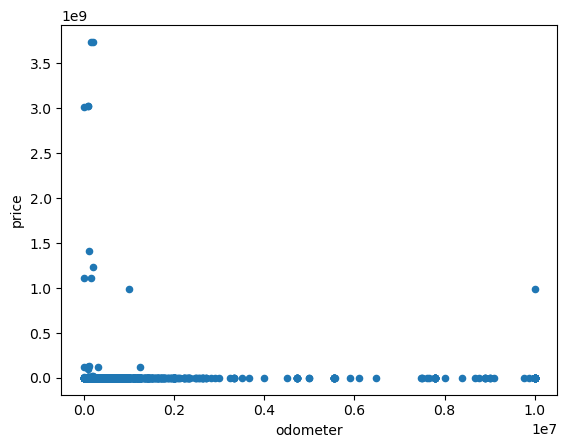

In [25]:
df_w_dummies.plot.scatter(x='odometer', y='price')

Why are there so many cars with a price of zero? Why are there cars worth over one billion dollars? We need to investigate and clean this up.

In [26]:
df_w_dummies['price'].sort_values()

id
7316457106             0
7308154134             0
7316993265             0
7308154157             0
7316991247             0
                 ...    
7314052904    3009548743
7309735768    3024942282
7309730903    3024942282
7308056031    3736928711
7302445002    3736928711
Name: price, Length: 421344, dtype: int64

In [27]:
print(len(df_w_dummies[df_w_dummies['price'] < 100]))
print(len(df_w_dummies[df_w_dummies['price'] >= 1_000_000]))

34078
60


We will eliminate the 34,078 cars with a value of less than 100, as they are not useful for our model. We will also eliminate 60 cars with a price of 1 million dollars or more, as they are extreme outliers (and possibly errors).

In [28]:
df_w_dummies = df_w_dummies[df_w_dummies['price'] >= 100]
df_w_dummies = df_w_dummies[df_w_dummies['price'] < 1_000_000]

In [29]:
df_w_dummies[df_w_dummies['price'] < 1000 ]

,price,year,odometer,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
id,,,,,,,,,,,,,,,,,,,,,
7316156727,500,2021.0,1400.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7315262722,500,2021.0,1400.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7314941829,199,2017.0,21737.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7314779644,500,2021.0,1400.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7314275443,500,2021.0,1400.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7301869705,800,1999.0,137000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7315020760,600,2002.0,150000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7314353850,500,2000.0,187000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In addition, the odometer values range up to 10 million miles, which is clearly a mistake. We will eliminate outliers and only consider vechiles with fewer than 400,000 miles.


In [30]:
print(len(df_w_dummies[df_w_dummies['odometer'] >= 400_000]))

1494


In [31]:
df_w_dummies = df_w_dummies[df_w_dummies['odometer'] < 400_000]

<Axes: xlabel='odometer', ylabel='price'>

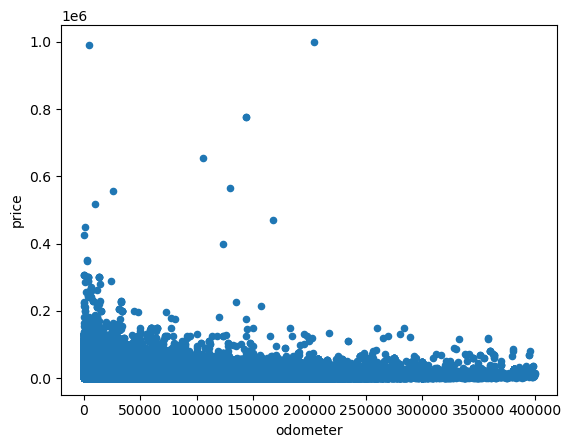

In [32]:
df_w_dummies.plot.scatter(x='odometer', y='price')

Looking closer at the data, I will eliminate the outliers with price > $350,000.

In [33]:
df_w_dummies = df_w_dummies[df_w_dummies['price'] < 350_000]

<Axes: xlabel='odometer', ylabel='price'>

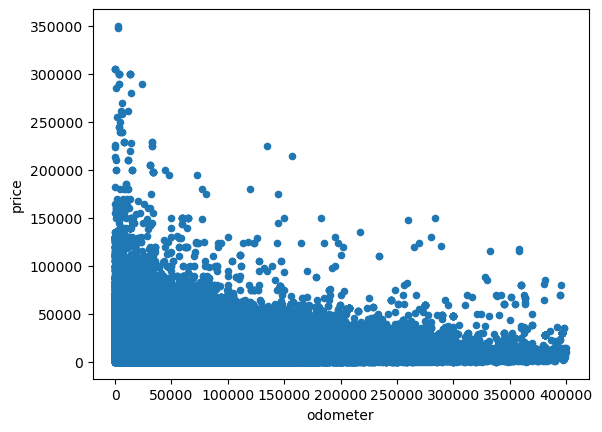

In [34]:
df_w_dummies.plot.scatter(x='odometer', y='price')

The above plot has the relationship I expected to see, a relatively negative correlation between odometer and price.

Since both price and odometer had some irregularities, let's double check year

<Axes: xlabel='year', ylabel='price'>

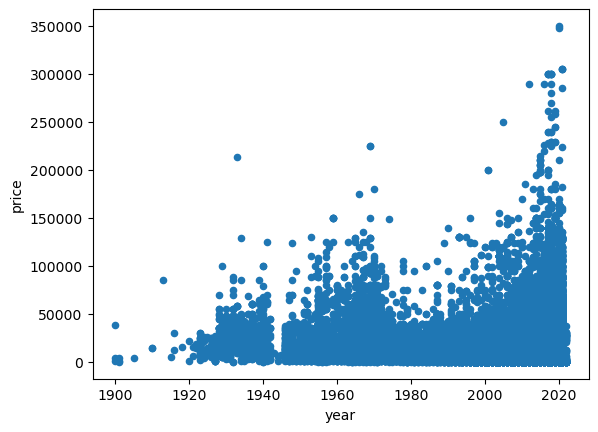

In [35]:
df_w_dummies.plot.scatter(x='year', y='price')

This shows a relatively positive correlation beteween year and price, which we expect. Let's double check the cars from before 1920 and ensure these are not mistakes.

In [36]:
df[df['year'] < 1920]

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
id,,,,,,,,,,,,,
7302752687,0,1903.0,chevrolet,NaN,NaN,gas,NaN,clean,NaN,NaN,other,NaN,al
7316727942,999,1901.0,NaN,NaN,NaN,gas,1.0,clean,automatic,NaN,NaN,NaN,az
7313460223,16000,1918.0,ford,good,4 cylinders,gas,56000.0,clean,automatic,rwd,convertible,red,ca
7316740981,1,1900.0,NaN,fair,other,other,100000.0,clean,other,NaN,other,custom,ca
7313782174,1,1900.0,NaN,fair,other,other,100000.0,clean,other,NaN,other,custom,ca
7315088892,38250,1900.0,acura,new,4 cylinders,gas,4500.0,clean,automatic,4wd,SUV,silver,ca
7311922008,1,1900.0,NaN,good,other,other,1000.0,clean,other,NaN,other,custom,ca
7316508257,85000,1913.0,cadillac,good,4 cylinders,gas,150.0,clean,manual,rwd,convertible,black,ca
7309914809,30000,1916.0,NaN,good,4 cylinders,gas,6008.0,clean,manual,NaN,NaN,red,ca


The above appear to be errors. I suspect this may be due to recording the year as two digits instead of four. To be safe, we'll eliminate all years prior to 1924.


In [37]:
df_w_dummies = df_w_dummies[df_w_dummies['year'] >= 1923]

In [38]:
df_w_dummies.corr()['price'].sort_values()

odometer                 -0.493833
fuel_gas                 -0.291311
cylinders_4 cylinders    -0.248625
drive_fwd                -0.240415
transmission_automatic   -0.195785
                            ...   
type_pickup               0.214356
fuel_diesel               0.260304
transmission_other        0.264751
year                      0.333614
price                     1.000000
Name: price, Length: 152, dtype: float64

With the elimination of the outliers, our data make much more sense. The year now has a positive correlation with price, and odometer has a negative correlation with price.


#### Scaling

Next, we will scale our data to apply equal weights to all features

In [39]:
ss = StandardScaler()
scaled_df = pd.DataFrame(ss.fit_transform(df_w_dummies), columns=ss.get_feature_names_out())

In [40]:
scaled_df.tail()

,price,year,odometer,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
385675,0.300927,0.838672,-0.950021,-0.121844,-0.047081,-0.007379,-0.13674,-0.190629,-0.115922,-0.131000,...,-0.056262,-0.166586,-0.239605,-0.053918,-0.151136,-0.078113,-0.180974,-0.172015,-0.050909,25.947365
385676,0.760783,0.944416,-1.268899,-0.121844,-0.047081,-0.007379,-0.13674,-0.190629,-0.115922,-0.131000,...,-0.056262,-0.166586,-0.239605,-0.053918,-0.151136,-0.078113,-0.180974,-0.172015,-0.050909,25.947365
385677,1.049835,0.944416,-1.392917,-0.121844,-0.047081,-0.007379,-0.13674,-0.190629,-0.115922,7.633581,...,-0.056262,-0.166586,-0.239605,-0.053918,-0.151136,-0.078113,-0.180974,-0.172015,-0.050909,25.947365
385678,0.655673,0.732929,-0.983398,-0.121844,-0.047081,-0.007379,-0.13674,-0.190629,-0.115922,-0.131000,...,-0.056262,-0.166586,-0.239605,-0.053918,-0.151136,-0.078113,-0.180974,-0.172015,-0.050909,25.947365
385679,0.760783,0.838672,-1.100168,-0.121844,-0.047081,-0.007379,-0.13674,5.245778,-0.115922,-0.131000,...,-0.056262,-0.166586,-0.239605,-0.053918,-0.151136,-0.078113,-0.180974,-0.172015,-0.050909,25.947365


In [41]:
scaled_df.corr()['price'].sort_values()

odometer                 -0.493833
fuel_gas                 -0.291311
cylinders_4 cylinders    -0.248625
drive_fwd                -0.240415
transmission_automatic   -0.195785
                            ...   
type_pickup               0.214356
fuel_diesel               0.260304
transmission_other        0.264751
year                      0.333614
price                     1.000000
Name: price, Length: 152, dtype: float64

#### Simple Cross Validation

Now we are ready to separate our training and testing data via simple cross validation.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df.drop('price', axis = 1), df_w_dummies['price'], test_size=0.3)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269976 entries, 127515 to 257374
Columns: 151 entries, year to state_wy
dtypes: float64(151)
memory usage: 313.1 MB


In [43]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115704 entries, 375865 to 54086
Columns: 151 entries, year to state_wy
dtypes: float64(151)
memory usage: 134.2 MB


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

We will attempt four model types and find the most accurate:
1. Simple linear regression
2. Regression with polynomial features
3. Sequential Feature Selection
4. Ridge regression
5. LASSO regression


#### Simple Linear Regression

This will give us some baseline MSE results to try to improve on with other models.

In [44]:
linear_pipe = Pipeline([
    ('linear', LinearRegression())
])
linear_pipe.fit(X_train, y_train)

Pipeline(steps=[('linear', LinearRegression())])

In [45]:
print('Linear Training MSE: ', mean_squared_error(linear_pipe.predict(X_train), y_train))
print('Linear Test MSE: ', mean_squared_error(linear_pipe.predict(X_test), y_test))

Linear Training MSE:  103768092.5481182
Linear Test MSE:  103133732.76988871


#### Polynomial Features

In [46]:
#poly_pipe = Pipeline([
#    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
#    ('linear', LinearRegression())
#])
#poly_pipe.fit(X_train, y_train)

Creating polynomial features gave an out-of-memory error. Looks like polynomial features will not be practical for 152 columns (unless I get more memory for my computer).

#### Sequential Feature Selection

In [47]:
sfs_pipe = Pipeline([
    ('selector', SequentialFeatureSelector(LinearRegression(), n_features_to_select=5)),
    ('linear', LinearRegression())
])
sfs_pipe.fit(X_train, y_train)

Pipeline(steps=[('selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=5)),
                ('linear', LinearRegression())])

In [48]:
print('SFS (5 features) Training MSE: ', mean_squared_error(sfs_pipe.predict(X_train), y_train))
print('SFS (5 features) Test MSE: ', mean_squared_error(sfs_pipe.predict(X_test), y_test))

SFS (5 features) Training MSE:  127181493.930617
SFS (5 features) Test MSE:  125870716.21961395


SFS took quite a long time for only 5 features, with a worse MSE than simple linear regression. Will try once more.

In [49]:
sfs_pipe = Pipeline([
    ('selector', SequentialFeatureSelector(LinearRegression(), n_features_to_select=10)),
    ('linear', LinearRegression())
])
sfs_pipe.fit(X_train, y_train)

Pipeline(steps=[('selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=10)),
                ('linear', LinearRegression())])

In [50]:
print('SFS (10 features) Training MSE: ', mean_squared_error(sfs_pipe.predict(X_train), y_train))
print('SFS (10 features) Test MSE: ', mean_squared_error(sfs_pipe.predict(X_test), y_test))

SFS (10 features) Training MSE:  117240576.4097213
SFS (10 features) Test MSE:  116760760.83854581


Even with 10 features, the model failed to reach the MSE of simple linear regression. The fitting took about 15 minutes to complete.

#### Ridge Regression

In [51]:
alphas = [0.0001,0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    print('Ridge with Alpha=', a,' Training MSE: ', mean_squared_error(ridge.predict(X_train), y_train))
    print('Ridge with Alpha=', a,' Test MSE: ', mean_squared_error(ridge.predict(X_train), y_train))
    


Ridge with Alpha= 0.0001  Training MSE:  103765476.98824583
Ridge with Alpha= 0.0001  Test MSE:  103765476.98824583
Ridge with Alpha= 0.001  Training MSE:  103765476.98824586
Ridge with Alpha= 0.001  Test MSE:  103765476.98824586
Ridge with Alpha= 0.1  Training MSE:  103765476.98828046
Ridge with Alpha= 0.1  Test MSE:  103765476.98828046
Ridge with Alpha= 1.0  Training MSE:  103765476.99170561
Ridge with Alpha= 1.0  Test MSE:  103765476.99170561
Ridge with Alpha= 10.0  Training MSE:  103765477.33348103
Ridge with Alpha= 10.0  Test MSE:  103765477.33348103
Ridge with Alpha= 100.0  Training MSE:  103765510.79047613
Ridge with Alpha= 100.0  Test MSE:  103765510.79047613
Ridge with Alpha= 1000.0  Training MSE:  103768298.2957412
Ridge with Alpha= 1000.0  Test MSE:  103768298.2957412


Ridge regression appears to give roughly equivalent results to simple linear regression.

#### Lasso Regression

In [52]:
lasso_pipe = Pipeline([
    ('lasso', Lasso(alpha=1000))
])

lasso_pipe.fit(X_train, y_train)

Pipeline(steps=[('lasso', Lasso(alpha=1000))])

In [53]:
lasso_pipe.named_steps['lasso'].coef_

array([ 2284.24754672, -6184.81737104,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,    -0.        ,
           0.        ,     0.        ,    -0.        ,     0.        ,
          -0.        ,   510.30821464,    -0.        ,     0.        ,
           0.        ,    -0.        ,    -0.        ,    -0.        ,
           0.        ,     0.        ,    -0.        ,    -0.        ,
          -0.        ,     0.        ,     0.        ,    -0.        ,
           0.        ,    -0.        ,    -0.        ,    -0.        ,
          -0.        ,    -0.        ,    -0.        ,     0.        ,
           0.        ,     0.        ,    -0.        ,    -0.        ,
           0.        ,     0.        ,    -0.        ,     0.        ,
          -0.        ,    -0.        ,     0.        ,    -0.        ,
           0.        ,    -0.        ,     0.        ,     0.        ,
          -0.        , -1329.8694961 ,    -0.        ,    -0.        ,
      

With alpha = 1000, only 13 features remain. 

In [54]:
print('Lasso Training MSE: ', mean_squared_error(lasso_pipe.predict(X_train), y_train))
print('Lasso Test MSE: ', mean_squared_error(lasso_pipe.predict(X_test), y_test))

Lasso Training MSE:  122759220.31967703
Lasso Test MSE:  121927470.7618297


Even though Lasso fails to improve on simple linear regression, we may be able to use this list of 13 features. Let's try linear regression with the features selected by Lasso.

In [55]:
model_selector_pipe = Pipeline([
    ('selector', SelectFromModel(Lasso(alpha=1000))),
    ('linreg', LinearRegression())
])

model_selector_pipe.fit(X_train, y_train)

Pipeline(steps=[('selector', SelectFromModel(estimator=Lasso(alpha=1000))),
                ('linreg', LinearRegression())])

In [56]:
print('Select from Model MSE: ', mean_squared_error(model_selector_pipe.predict(X_train), y_train))
print('Select from Model MSE: ', mean_squared_error(model_selector_pipe.predict(X_test), y_test))

Select from Model MSE:  115317228.66774063
Select from Model MSE:  114968873.55628155


This did not improve our MSE, but perhaps we can look at the features Lasso selected and do more with them.

#### Analysis

Let's compare the 13 features chosen by lasso with the 10 features chosen by sequential feature selection and the top features chosen by the correlation matrix.

##### Lasso features

In [57]:
pd.DataFrame(zip(lasso_pipe.named_steps['lasso'].coef_, X_train)).sort_values(0).head(6)

,0,1
1,-6184.817371,odometer
53,-1329.869496,cylinders_4 cylinders
73,-1253.648965,drive_fwd
60,-804.937956,fuel_gas
84,-246.178119,type_sedan
75,-0.000000,type_SUV


In [58]:
pd.DataFrame(zip(lasso_pipe.named_steps['lasso'].coef_, X_train)).sort_values(0, ascending=False).head(9)

,0,1
58,2585.171783,fuel_diesel
0,2284.247547,year
72,902.858372,drive_4wd
56,780.343405,cylinders_8 cylinders
83,759.123609,type_pickup
13,510.308215,manufacturer_ferrari
85,411.310255,type_truck
63,138.518458,title_status_clean
98,0.000000,paint_color_white


##### SFS Features

In [59]:
sfs_pipe.named_steps['selector'].support_
X_train.iloc[:,sfs_pipe.named_steps['selector'].support_].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269976 entries, 127515 to 257374
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   year                   269976 non-null  float64
 1   odometer               269976 non-null  float64
 2   manufacturer_ferrari   269976 non-null  float64
 3   cylinders_4 cylinders  269976 non-null  float64
 4   cylinders_8 cylinders  269976 non-null  float64
 5   fuel_diesel            269976 non-null  float64
 6   title_status_clean     269976 non-null  float64
 7   drive_4wd              269976 non-null  float64
 8   drive_fwd              269976 non-null  float64
 9   type_pickup            269976 non-null  float64
dtypes: float64(10)
memory usage: 22.7 MB


There is total agreement! 

##### Correlation Matrix Features

In [60]:
df_w_dummies.corr()['price'].sort_values().head(8)

odometer                 -0.493833
fuel_gas                 -0.291311
cylinders_4 cylinders    -0.248625
drive_fwd                -0.240415
transmission_automatic   -0.195785
type_sedan               -0.159075
condition_fair           -0.129811
condition_excellent      -0.126792
Name: price, dtype: float64

In [61]:
df_w_dummies.corr()['price'].sort_values(ascending=False).head(8)

price                 1.000000
year                  0.333614
transmission_other    0.264751
fuel_diesel           0.260304
type_pickup           0.214356
drive_4wd             0.200149
fuel_other            0.166334
type_truck            0.158461
Name: price, dtype: float64

Once again, there is a lot of agreement. 

We will make one more attempt at a model with a reduced feature set, but adding polynomial features. The set below has the features names by at least two of the three feature selection tools.

In [62]:
reduced_df = scaled_df[['odometer','cylinders_4 cylinders', 'cylinders_8 cylinders', 'drive_fwd', 'drive_4wd',  \
                        'fuel_gas', 'fuel_diesel', 'type_sedan', 'type_pickup', 'type_truck', 'year', \
                        'price']]

In [63]:
X2_train, X2_test, y2_train, y2_test = train_test_split(reduced_df.drop('price', axis = 1), reduced_df['price'], test_size=0.3)

In [64]:
poly2_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('linear', LinearRegression())
])
poly2_pipe.fit(X2_train, y2_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('linear', LinearRegression())])

In [65]:
print('Polynomial Features (top 11) Training MSE: ', mean_squared_error(poly2_pipe.predict(X2_train), y2_train))
print('Polynomial Features (top 11) Test MSE: ', mean_squared_error(poly2_pipe.predict(X2_test), y2_test))

Polynomial Features (top 11) Training MSE:  0.4147361827707379
Polynomial Features (top 11) Test MSE:  0.40257850379721155


Wow! This model is many orders of magnitude better than anything we've seen before. Let's try it with SFS, Ridge, and Lasso to see if we can improve it.

In [66]:
poly_sfs_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('sfs', SequentialFeatureSelector(LinearRegression(), n_features_to_select=5)),
    ('linear', LinearRegression())
])
poly_sfs_pipe.fit(X2_train, y2_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('sfs',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=5)),
                ('linear', LinearRegression())])

In [67]:
print('Polynomial Features with SFS Training MSE: ', mean_squared_error(poly_sfs_pipe.predict(X2_train), y2_train))
print('Polynomial Features with SFS Test MSE: ', mean_squared_error(poly_sfs_pipe.predict(X2_test), y2_test))

Polynomial Features with SFS Training MSE:  0.5359075427211785
Polynomial Features with SFS Test MSE:  0.5266306882991377


In [68]:
poly_sfs_pipe2 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('sfs', SequentialFeatureSelector(LinearRegression(), n_features_to_select=7)),
    ('linear', LinearRegression())
])
poly_sfs_pipe2.fit(X2_train, y2_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('sfs',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=7)),
                ('linear', LinearRegression())])

In [69]:
print('Polynomial Features with SFS Training MSE: ', mean_squared_error(poly_sfs_pipe2.predict(X2_train), y2_train))
print('Polynomial Features with SFS Test MSE: ', mean_squared_error(poly_sfs_pipe2.predict(X2_test), y2_test))

Polynomial Features with SFS Training MSE:  0.4872051755188202
Polynomial Features with SFS Test MSE:  0.47678533326384165


In [70]:
poly_sfs_pipe3 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('sfs', SequentialFeatureSelector(LinearRegression(), n_features_to_select=10)),
    ('linear', LinearRegression())
])
poly_sfs_pipe3.fit(X2_train, y2_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('sfs',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=10)),
                ('linear', LinearRegression())])

In [71]:
print('Polynomial Features with SFS Training MSE: ', mean_squared_error(poly_sfs_pipe3.predict(X2_train), y2_train))
print('Polynomial Features with SFS Test MSE: ', mean_squared_error(poly_sfs_pipe3.predict(X2_test), y2_test))

Polynomial Features with SFS Training MSE:  0.4619600181973793
Polynomial Features with SFS Test MSE:  0.4514474095507101


In [72]:
poly_sfs_pipe4 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('sfs', SequentialFeatureSelector(LinearRegression(), n_features_to_select=15)),
    ('linear', LinearRegression())
])
poly_sfs_pipe4.fit(X2_train, y2_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('sfs',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=15)),
                ('linear', LinearRegression())])

In [73]:
print('Polynomial Features with SFS Training MSE: ', mean_squared_error(poly_sfs_pipe4.predict(X2_train), y2_train))
print('Polynomial Features with SFS Test MSE: ', mean_squared_error(poly_sfs_pipe4.predict(X2_test), y2_test))

Polynomial Features with SFS Training MSE:  0.4366605277475165
Polynomial Features with SFS Test MSE:  0.4253795959071788


In [74]:
poly_lasso_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('lasso', Lasso(alpha=.0001))
])
poly_lasso_pipe.fit(X2_train, y2_train)

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.165e+03, tolerance: 2.706e+01
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('lasso', Lasso(alpha=0.0001))])

In [75]:
poly_lasso_pipe.named_steps['lasso'].coef_

array([-0.36995679, -0.09905358,  0.09752851, -0.07808657,  0.07601719,
       -0.05705892,  0.11780198, -0.0218678 ,  0.04833288,  0.0144686 ,
        0.53983076,  0.06244771,  0.05122248, -0.06512603,  0.04973688,
       -0.01214229, -0.00546515, -0.00097786,  0.01221637,  0.03631571,
        0.01622757, -0.086404  , -0.02164868, -0.        ,  0.02439865,
       -0.01197886,  0.00340334, -0.01529206,  0.01630238, -0.00389544,
       -0.00224738, -0.03753868,  0.04558297,  0.05822637, -0.00665184,
       -0.04863231, -0.04913797, -0.02268638, -0.04659412, -0.04007583,
        0.0105995 , -0.        , -0.        ,  0.00293826, -0.05498487,
       -0.01058984,  0.02768576,  0.        ,  0.00265273,  0.        ,
       -0.00467248, -0.00948532, -0.01415333,  0.03120318,  0.01508619,
        0.05295858, -0.00283901, -0.01066181, -0.00475118, -0.00667511,
        0.02111711, -0.01366141,  0.00590841, -0.07668595, -0.01062421,
        0.01103559,  0.0862741 , -0.03610307, -0.        , -0.  

In [76]:
print('Polynomial Features with Lasso Training MSE: ', mean_squared_error(poly_lasso_pipe.predict(X2_train), y2_train))
print('Polynomial Features with Lasso Test MSE: ', mean_squared_error(poly_lasso_pipe.predict(X2_test), y2_test))

Polynomial Features with Lasso Training MSE:  0.4147381433226635
Polynomial Features with Lasso Test MSE:  0.40258428166375454


In [77]:
poly_ridge_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('ridge', Ridge(alpha=100))
])
poly_ridge_pipe.fit(X2_train, y2_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge(alpha=100))])

In [78]:
print('Polynomial Features with Ridge Training MSE: ', mean_squared_error(poly_ridge_pipe.predict(X2_train), y2_train))
print('Polynomial Features with Ridge Test MSE: ', mean_squared_error(poly_ridge_pipe.predict(X2_test), y2_test))

Polynomial Features with Ridge Training MSE:  0.41473631813720796
Polynomial Features with Ridge Test MSE:  0.4025783765245659


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Our best model appears to be the 11 features (selected with a combination of SFS, Lasso, and correlation), with polynomial degree 2, and then using Ridge regression. Let's look at the coefficients of that model to rank them.

In [79]:
pd.DataFrame(zip(poly_lasso_pipe.named_steps['lasso'].coef_, X2_train)).sort_values(0).head(12)

,0,1
0,-0.369957,odometer
1,-0.099054,cylinders_4 cylinders
3,-0.078087,drive_fwd
5,-0.057059,fuel_gas
7,-0.021868,type_sedan
9,0.014469,type_truck
8,0.048333,type_pickup
4,0.076017,drive_4wd
2,0.097529,cylinders_8 cylinders
6,0.117802,fuel_diesel


When ranking the importance of the features, we will take into account the delta between a positive and negative feature of the same type (e.g., gas vs. diesel fuel).

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

In examining the dataset, we have created a model and determined the most important features affecting the price of a used car. The following list ranks the features in order of importance. We have added a "star rating," to give a sense of the importance of each feature on the price.

1. Year - 5 stars - The vehicle year has an strong and nonlinear relationship with price, see chart below
2. Odometer - 3 stars - Unsuprisingly, lower mileage is more expensive
3. Number of Cylinders - 2 stars - 8 is most expensive, 4 is least expensive
4. Fuel type - 1.5 stars - Vehicles with diesel engines are most expensive, followed by other (hybrid), followed by regular gasoline
5. Drive type - 1.5 stars - 4 wheel drive is most expensive, front wheel drive is least expensive
6. Vehicle type - 0.5 stars - Truck/pickup is most expensive, sedan is least expensive

<Axes: xlabel='year', ylabel='price'>

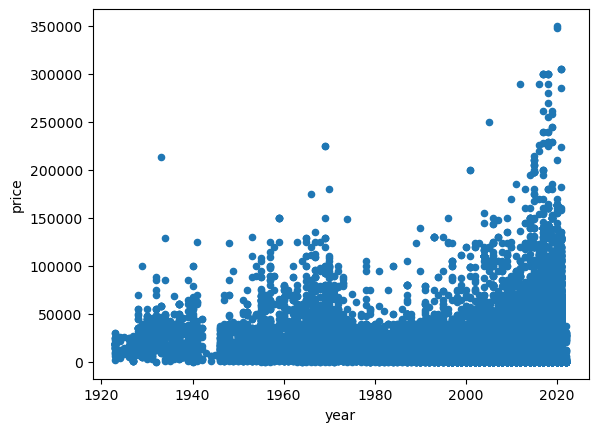

In [80]:
df_w_dummies.plot.scatter(x='year', y='price')

Notice, the relationship between year and price is not entirely linear. There is increased value in the years 1953 - 1973. From 1973-2000 the price stays roughly flat, and then steadily increases between 2000 and 2022.